# 2025-10-27 Gradient Descent

* Discuss projects

* Gradient-based optimization for linear models

* Nonlinear models

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# And for piecewise constant interpolation
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end

# A utility for evaluating our regression
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Projects

Work in your groups to coordinate in person form a brief summary of your progress.
Briefly tell the class

1) One interesting thing about the process

2) One question you have relevant to the projects (specific or general)

3) One question from content we've covered in relation to your project

## Optimization

Ok, now we can start putting pieces together.

Given data $\left( x, y \right)$ and loss function $L \left( c; x, y \right)$, we wish to find the coefficients $c$ that minimize the loss, thus yielding the "best predictor" (in a sense that can be made statistically precise). I.e.,

$$ \bar{c} = \arg \min_c L \left( c; x, y \right) $$

It is usually desirable to design models such that the loss function is differentiable with respect to the coefficients $c$, because this allows the use of more efficient optimization methods.

Recall that our forward model is given in terms of the Vandermonde matrix,

$$ f \left( x, c \right) = V \left( x \right) c $$

and thus

$$ \frac{\partial f}{\partial c} = V \left( x \right) $$

## Derivative of loss function

We can now differentiate our loss function

$$ L \left( c; x, y \right) = \frac{1}{2} \left\lvert \left\lvert f \left( x, c \right) - y \right\rvert \right\rvert^2 = \frac{1}{2} \sum_i \left( f \left( x_i, c \right) - y_i \right)^2 $$

using a more linear algebraic approach to write

$$ \begin{align}
\nabla_c L \left( c; x, y \right)
 &= \left( f \left( x, c \right) - y \right)^T V \left( x \right) \\
 &= \left( V \left( x \right) c - y \right)^T V \left( x \right) \\
 &= V \left( x \right)^T \left( V \left( x \right) c - y \right)
\end{align} $$

A necessary condition for the loss function to be minimized is that $ \nabla_c L \left( c; x, y \right) = 0$.

## Gradient descent

Instead of solving the least squares problem using linear algebra (QR factorization), we could solve it using gradient descent.
That is, on each iteration, we'll take a step in the direction of the negative gradient.

In [2]:
function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

Gradient descent shows quadratic convergence.

svdvals(A) = [16.066372975210776, 0.9336270247892221]


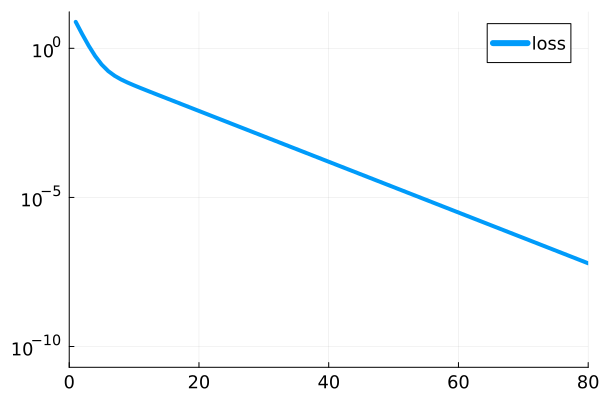

In [3]:
A = [1 1; 1 16]
@show svdvals(A)
loss(c) = .5 * c' * A * c
grad(c) = A * c

c, chist, lhist = grad_descent(loss, grad, [.9, .9],
    gamma=.1)
plot(lhist, yscale=:log10, xlims=(0, 80), label="loss")

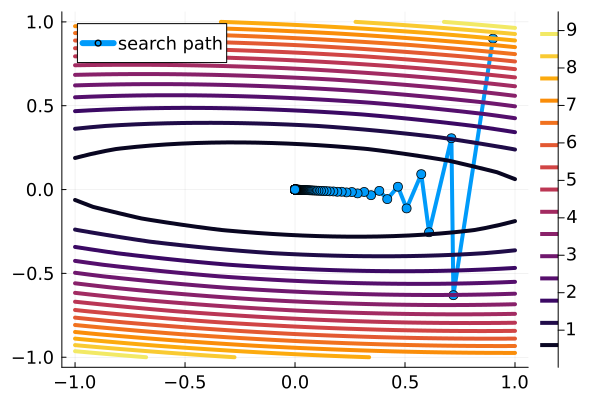

In [4]:
plot(chist[1, :], chist[2, :], marker=:circle, label="search path")
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

Note that the [Conjugate Gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) takes this idea and combines it with the idea of Krylov subspaces from the homework assignment.

## Chebyshev regression via optimization

Let's try to fit our function that shows the Runge phenomenon with noise.

In [5]:
# Set up the problem to solve
x = LinRange(-1, 1, 200)
sigma = 0.5
y = runge_noisy(x, sigma)
n = 8
V = vander(x, n)

# Here's our loss function
function loss(c)
    r = V * c - y
    .5 * r' * r
end
# and our gradient
function grad(c)
    r = V * c - y
    V' * r
end

# Solve
c, _, lhist = grad_descent(loss, grad, ones(n),
    gamma=0.008)
# and our final coefficients are....
@show c;

c = [0.7907196035247224, 0.0351323761707806, -1.7267621580288868, 0.16122658782076174, 0.5594554689575836, -0.10295262983550399, 0.5577334628458773, -0.1294880441222878]


cond(V' * V) = 52902.529947850875


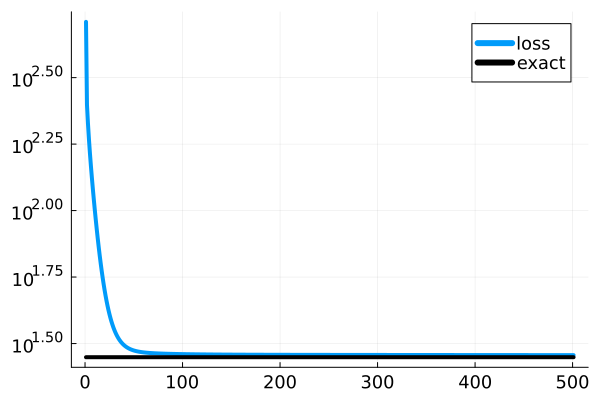

In [6]:
c0 = V \ y # Solve exactly
l0 = 0.5 * norm(V * c0 - y)^2
@show cond(V' * V)

plot(lhist, yscale=:log10, label="loss")
plot!(i -> l0, color=:black, label="exact")

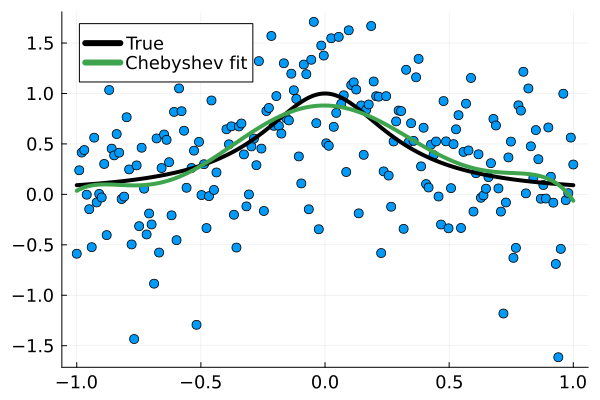

In [7]:
scatter(x, y, label=:none)
V = vander_chebyshev(x, 7)
plot!(x -> runge(x), color=:black, label="True")
plot!(x, V * (V \ y), label="Chebyshev fit")

## But why

Why would we use gradient-based optimization vs QR or other direct solves?

## Nonlinear models

Instead of the linear model

$$ f \left( x, c \right) = V \left( x \right) c = c_0 + c_1 T_1 \left( x \right) + c_2 T_2 \left( x \right) + \cdots $$

let's consider a rational model with only three parameters

$$ f \left( x, c \right) = \frac{1}{c_1 + c_2 x + c_3 x^2} = \left( c_1 + c_2 x + c_3 x^2 \right)^{-1} $$

We'll use the same loss function

$$ L \left( c; x, y \right) = \frac{1}{2} \left\lvert \left\lvert f \left( x, c \right) - y \right\rvert \right\rvert^2 $$

We will also need the gradient

$$ \nabla_c L \left( c; x, y \right) = \left( f \left( x, c \right) - y \right)^T \nabla_c f \left( x, c \right) $$

where

$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} = - f \left( x, c \right)^2 $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x = - f \left( x, c \right)^2 x $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x^2 = - f \left( x, c \right)^2 x^2 $$

## Fitting a rational function

Now let's fit our rational function with gradient descent, as above.

In [8]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)

function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end

function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end

function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

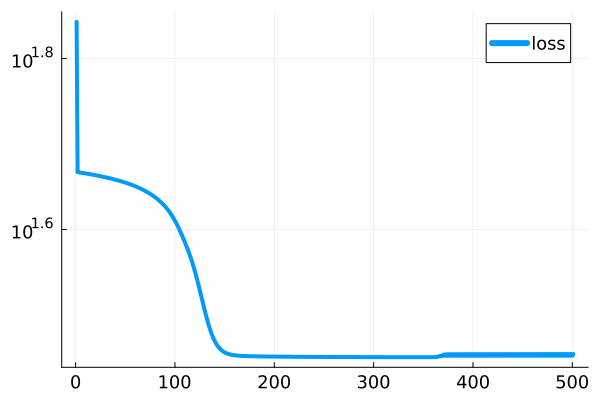

In [9]:
c, _, lhist = grad_descent(loss, gradient, ones(3), gamma=8e-2)
plot(lhist, yscale=:log10, label="loss")

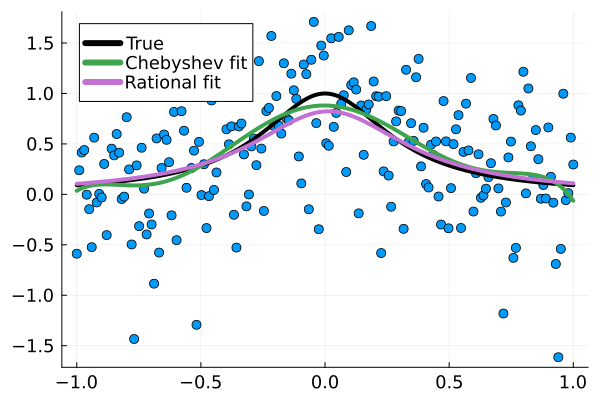

In [10]:
scatter(x, y, label=:none)
V = vander_chebyshev(x, 7)
plot!(x -> runge(x), color=:black, label="True")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")